# В данной работе реализуем класс для алгоритма k-means

Импортируем необходимые библиотеки, в том числе для графической интепретации результатов

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

Осуществляем сбор данных. Я решил использовать готовый датасет с Kaggle, который я загрузил на гугл диск и прочитал с помощью read_html. Он содержит информацию о характеристиках клиентов для сегментации рынка.

In [89]:
X = pd.read_html('https://docs.google.com/spreadsheets/d/18WwhPecptJPmTvh2yjyh07Ir8QBLXrNlZQfSzgcxv8A/edit?gid=1020354482#gid=1020354482')[0]
X.columns = X.iloc[0, :].values
X = X.iloc[1:, :].drop([1], axis=1)
X.index = X['CustomerID']
X = X.drop(['CustomerID'], axis=1)
X.columns = ['Gender', 'Age', 'Income', 'Score']
X['Gender'] = X['Gender'].apply(lambda x: 1 if x=='Male' else 0)
X = X.astype(float)
X = X.drop(['Gender'], axis=1)
X.head()

,Age,Income,Score
CustomerID,,,
1,19.0,15.0,39.0
2,21.0,15.0,81.0
3,20.0,16.0,6.0
4,23.0,16.0,77.0
5,31.0,17.0,40.0


Моя реализация класса в качестве начальных центроидов использует случайно выбранные объекты датафрейма вместо случайных точек в пространстве, что должно повысить точность предсказаний. Также внутри метода fit проводится стандартизация данных, чтобы избежать ошибок из-за различий в единицах измерения признаков.

In [90]:
class MyKMeans:
  def __init__(self, n_clusters=3, max_iter=3, n_init=3, random_state=42):
    self.n_clusters = n_clusters
    self.max_iter = max_iter
    self.n_init = n_init
    self.random_state = random_state

  def __str__(self):
    return f'MyKMeans class: n_clusters={self.n_clusters}, max_iter={self.max_iter}, n_init={self.n_init}, random_state={self.random_state}'

  def fit(self, X: pd.DataFrame):
    np.random.seed(self.random_state)
    best_inertia  = np.inf
    self.best_centroids = None
    self.scaler = StandardScaler() #используем стандартизацию чтобы повысить точность
    X = pd.DataFrame(self.scaler.fit_transform(X.values), index=X.index, columns=X.columns)

    #запускаем алгоритм несколько раз для отбора лучшего варианта кластеризации
    for n in range(self.n_init):
      self.initial_centroids = X.sample(self.n_clusters, random_state=self.random_state+n).to_numpy()
      initial_clusters = []

      #устанавливаем максимальное количество итераций на случай, если центры тяжести кластеров не стабилизируются
      for iter in range(self.max_iter):
        distances = np.linalg.norm(self.initial_centroids - X.to_numpy()[:, np.newaxis], axis=2)
        clusters = np.argmin(distances, axis=1)
        self.new_centroids = []

        #для каждого кластера рассчитываем центры тяжести и сохраняем
        for i in range(self.n_clusters):
          cluster_points = X.to_numpy()[clusters==i]
          if len(cluster_points)>0:
            self.new_centroids.append(np.mean(cluster_points, axis=0))
          else:
            self.new_centroids.append(self.initial_centroids[i])
        self.new_centroids = np.array(self.new_centroids)

        #считаем расстояния от объектов до центров тяжести и распределяем объекты по ближайшим кластерам
        new_distances = np.linalg.norm(self.new_centroids - X.to_numpy()[:, np.newaxis], axis=2)
        if (self.new_centroids==self.initial_centroids).all():
          break
        self.initial_centroids = self.new_centroids

      #рассчитываем значение WCSS и сравниваем с лучшим: если новое получилось меньше, то теперь считаем ее лучшей
      new_inertia = np.sum(np.min(distances**2, axis=1))
      if new_inertia<best_inertia:
        best_inertia = new_inertia
        self.best_centroids = self.new_centroids

    self.cluster_centers_ = self.best_centroids
    self.inertia_ = best_inertia

    return best_inertia, np.sum(self.best_centroids)

  def predict(self, X):
    return np.argmin(np.linalg.norm(self.cluster_centers_ - self.scaler.transform(X)[:, np.newaxis], axis=2), axis=1)

## Обучим нашу модель и посмотрим на разделение по кластерам

#### Поскольку в датафрейме присутствует 4 признака, графически отобразим все, кроме пола

In [91]:
model = MyKMeans()
model.fit(X)
clusters = model.predict(X)
clusters, model.inertia_

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(array([2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
        0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2,
        0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 116.04519925234625)

<Figure size 640x480 with 0 Axes>

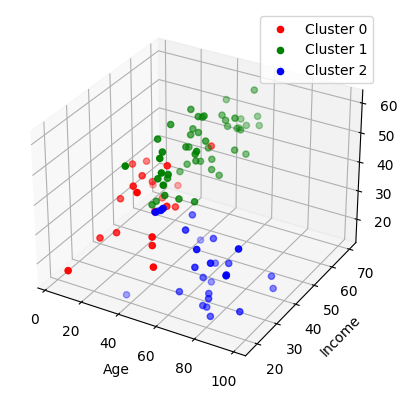

In [92]:
fig = plt.figure()
colors = ['r', 'g', 'b']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Отрисовка точек
for cluster in np.unique(clusters):
    x = X[clusters == cluster]['Score']
    y = X[clusters == cluster]['Age']
    z = X[clusters == cluster]['Income']
    ax.scatter(x, y, z, color=colors[cluster], label=f'Cluster {cluster}')

ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Score')
ax.legend()
plt.show()

Как мы видим, результат в какой-то мере понятен интуитивно, но в то же время отделение 1 кластера кажется довольно неочевидным из-за его пересечения со вторым. Тем не менее, если оценивать значения WCSS модели, то можно сказать, что модель кластеризует объекты выборки достаточно качественно.

In [96]:
from sklearn.cluster import KMeans
model = KMeans(3, n_init=3, random_state=42)
model.fit(X)
clusters = model.predict(X)

In [97]:
clusters

array([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 0,
       1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

<Figure size 640x480 with 0 Axes>

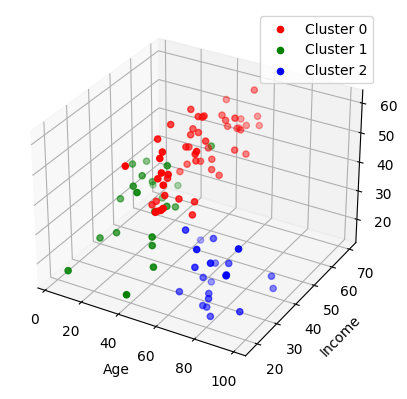

In [98]:
fig = plt.figure()
colors = ['r', 'g', 'b']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Отрисовка точек
for cluster in np.unique(clusters):
    x = X[clusters == cluster]['Score']
    y = X[clusters == cluster]['Age']
    z = X[clusters == cluster]['Income']
    ax.scatter(x, y, z, color=colors[cluster], label=f'Cluster {cluster}')

ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Score')
ax.legend()
plt.show()

### Вывод
Результаты реализованной мной модели и модели из библиотеки sklearn дают практически идентичные результаты кластеризации выбранных объектов, а значит, цель работы достигнута.